In [1]:
import gym
import numpy as np
import torch

# import environments
import envs.pomdp

# import recurrent model-free RL (separate architecture)
from policies.models.policy_rnn import ModelFreeOffPolicy_Separate_RNN as Policy_RNN

# import the replay buffer
from buffers.seq_replay_buffer_vanilla import SeqReplayBuffer
from utils import helpers as utl

/home/solozabal/miniforge3/envs/pomdp/lib/python3.8/site-packages/gym/envs/registration.py:423: UserWarning: WARN: Custom namespace `ALE` is being overridden by namespace `ALE`. If you are developing a plugin you shouldn't specify a namespace in `register` calls. The namespace is specified through the entry point package metadata.
  logger.warn(
/home/solozabal/miniforge3/envs/pomdp/lib/python3.8/site-packages/gym/utils/env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/home/solozabal/miniforge3/envs/pomdp/lib/python3.8/site-packages/gym/envs/registration.py:568: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/solozabal/miniforge3/envs/pomdp/lib/python3.8/site-packages/gym/envs/registration.py:407: UserWarning: WARN: The `registry.env_specs` prop

argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=


/home/solozabal/Documents/projects/rl-spike/pomdp-baselines/utils/logger.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import OrderedDict, Set
/home/solozabal/miniforge3/envs/pomdp/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:3: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [2]:
import torchkit.pytorch_utils as ptu

## Build a POMDP environment: Pendulum-V (only observe the velocity)

In [3]:
cuda_id = 0  # -1 if using cpu
ptu.set_gpu_mode(torch.cuda.is_available() and cuda_id >= 0, cuda_id)

env_name = "Pendulum-V-v0"
env = gym.make(env_name)
max_trajectory_len = env._max_episode_steps
act_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]
print(env, obs_dim, act_dim, max_trajectory_len)

<TimeLimit<OrderEnforcing<POMDPWrapper<TimeLimit<OrderEnforcing<PendulumEnv<Pendulum-V-v0>>>>>>> 1 1 200


/home/solozabal/miniforge3/envs/pomdp/lib/python3.8/site-packages/gym/utils/env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


## Build a recurent model-free RL agent: separate architecture, `lstm` encoder, `oar` policy input space, `td3` RL algorithm (context length set later)

In [10]:
agent = Policy_RNN(
    obs_dim=obs_dim,
    action_dim=act_dim,
    encoder="lstm",
    algo_name="td3",
    action_embedding_size=8,
    observ_embedding_size=32,
    reward_embedding_size=8,
    rnn_hidden_size=128,
    dqn_layers=[128, 128],
    policy_layers=[128, 128],
    lr=0.0003,
    gamma=0.9,
    tau=0.005,
).to(ptu.device)

## Define other training parameters such as context length and training frequency

In [5]:
num_updates_per_iter = 1.0  # training frequency
sampled_seq_len = 64  # context length
buffer_size = 1e6
batch_size = 32

num_iters = 150
num_init_rollouts_pool = 5
num_rollouts_per_iter = 1
total_rollouts = num_init_rollouts_pool + num_iters * num_rollouts_per_iter
n_env_steps_total = max_trajectory_len * total_rollouts
_n_env_steps_total = 0
print("total env episodes", total_rollouts, "total env steps", n_env_steps_total)

total env episodes 155 total env steps 31000


## Define key functions: collect rollouts and policy update

In [6]:
@torch.no_grad()
def collect_rollouts(
    num_rollouts, random_actions=False, deterministic=False, train_mode=True
):
    """collect num_rollouts of trajectories in task and save into policy buffer
    :param
        random_actions: whether to use policy to sample actions, or randomly sample action space
        deterministic: deterministic action selection?
        train_mode: whether to train (stored to buffer) or test
    """
    if not train_mode:
        assert random_actions == False and deterministic == True

    total_steps = 0
    total_rewards = 0.0

    for idx in range(num_rollouts):
        steps = 0
        rewards = 0.0
        obs = ptu.from_numpy(env.reset())
        obs = obs.reshape(1, obs.shape[-1])
        done_rollout = False

        # get hidden state at timestep=0, None for mlp
        action, reward, internal_state = agent.get_initial_info()

        if train_mode:
            # temporary storage
            obs_list, act_list, rew_list, next_obs_list, term_list = (
                [],
                [],
                [],
                [],
                [],
            )

        while not done_rollout:
            if random_actions:
                action = ptu.FloatTensor([env.action_space.sample()])  # (1, A)
            else:
                # policy takes hidden state as input for rnn, while takes obs for mlp
                (action, _, _, _), internal_state = agent.act(
                    prev_internal_state=internal_state,
                    prev_action=action,
                    reward=reward,
                    obs=obs,
                    deterministic=deterministic,
                )
            # observe reward and next obs (B=1, dim)
            next_obs, reward, done, info = utl.env_step(env, action.squeeze(dim=0))
            done_rollout = False if ptu.get_numpy(done[0][0]) == 0.0 else True

            # update statistics
            steps += 1
            rewards += reward.item()

            # early stopping env: such as rmdp, pomdp, generalize tasks. term ignores timeout
            term = (
                False
                if "TimeLimit.truncated" in info or steps >= max_trajectory_len
                else done_rollout
            )

            if train_mode:
                # append tensors to temporary storage
                obs_list.append(obs)  # (1, dim)
                act_list.append(action)  # (1, dim)
                rew_list.append(reward)  # (1, dim)
                term_list.append(term)  # bool
                next_obs_list.append(next_obs)  # (1, dim)

            # set: obs <- next_obs
            obs = next_obs.clone()

        if train_mode:
            # add collected sequence to buffer
            policy_storage.add_episode(
                observations=ptu.get_numpy(torch.cat(obs_list, dim=0)),  # (L, dim)
                actions=ptu.get_numpy(torch.cat(act_list, dim=0)),  # (L, dim)
                rewards=ptu.get_numpy(torch.cat(rew_list, dim=0)),  # (L, dim)
                terminals=np.array(term_list).reshape(-1, 1),  # (L, 1)
                next_observations=ptu.get_numpy(
                    torch.cat(next_obs_list, dim=0)
                ),  # (L, dim)
            )
        print(
            "Mode:",
            "Train" if train_mode else "Test",
            "env_steps",
            steps,
            "total rewards",
            rewards,
        )
        total_steps += steps
        total_rewards += rewards

    if train_mode:
        return total_steps
    else:
        return total_rewards / num_rollouts


def update(num_updates):
    rl_losses_agg = {}
    # print(num_updates)
    for update in range(num_updates):
        # sample random RL batch: in transitions
        batch = ptu.np_to_pytorch_batch(policy_storage.random_episodes(batch_size))
        # RL update
        rl_losses = agent.update(batch)

        for k, v in rl_losses.items():
            if update == 0:  # first iterate - create list
                rl_losses_agg[k] = [v]
            else:  # append values
                rl_losses_agg[k].append(v)
    # statistics
    for k in rl_losses_agg:
        rl_losses_agg[k] = np.mean(rl_losses_agg[k])
    return rl_losses_agg

## Train and Evaluate the agent: only costs < 20 min

In [9]:
policy_storage = SeqReplayBuffer(
    max_replay_buffer_size=int(buffer_size),
    observation_dim=obs_dim,
    action_dim=act_dim,
    sampled_seq_len=sampled_seq_len,
    sample_weight_baseline=0.0,
)

env_steps = collect_rollouts(
    num_rollouts=num_init_rollouts_pool, random_actions=True, train_mode=True
)
_n_env_steps_total += env_steps

# evaluation parameters
last_eval_num_iters = 0
log_interval = 5
eval_num_rollouts = 10
learning_curve = {
    "x": [],
    "y": [],
}

while _n_env_steps_total < n_env_steps_total:

    env_steps = collect_rollouts(num_rollouts=num_rollouts_per_iter, train_mode=True)
    _n_env_steps_total += env_steps

    train_stats = update(int(num_updates_per_iter * env_steps))

    current_num_iters = _n_env_steps_total // (
        num_rollouts_per_iter * max_trajectory_len
    )
    if (
        current_num_iters != last_eval_num_iters
        and current_num_iters % log_interval == 0
    ):
        last_eval_num_iters = current_num_iters
        average_returns = collect_rollouts(
            num_rollouts=eval_num_rollouts,
            train_mode=False,
            random_actions=False,
            deterministic=True,
        )
        learning_curve["x"].append(_n_env_steps_total)
        learning_curve["y"].append(average_returns)
        print(_n_env_steps_total, average_returns)

buffer RAM usage: 0.02 GB
Mode: Train env_steps 200 total rewards -774.3188773952425
Mode: Train env_steps 200 total rewards -852.4889237741008
Mode: Train env_steps 200 total rewards -1562.3696451187134
Mode: Train env_steps 200 total rewards -971.7877926528454
Mode: Train env_steps 200 total rewards -877.3423518612981


TypeError: only integer tensors of a single element can be converted to an index

## Draw the learning curve

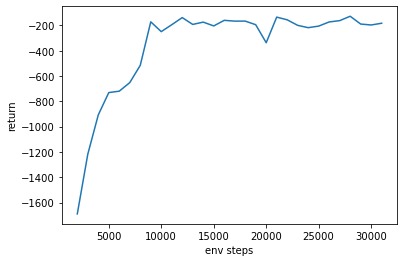

In [60]:
import matplotlib.pyplot as plt

plt.plot(learning_curve["x"], learning_curve["y"])
plt.xlabel("env steps")
plt.ylabel("return")
plt.show()